In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


# Load the datasets
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())
print(engagements.head())
print(marketing.head())


   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [32]:
# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

In [33]:

# Check for missing values in the customers dataset
print(customers.isnull().sum())

# Fill missing values for gender with "Unknown"
customers['gender'].fillna('Unknown', inplace=True)

# Display columns with missing values
print(customers[customers.isnull().any(axis=1)])

customer_id              0
join_date                0
last_purchase_date       0
age                   1009
gender                 533
location                 0
dtype: int64
      customer_id  join_date last_purchase_date  age   gender  \
1               2 2021-09-08         2023-10-25  NaN     Male   
2               3 2021-06-01         2022-11-27  NaN  Unknown   
4               5 2022-01-24         2023-06-02  NaN     Male   
6               7 2023-12-11         2024-05-29  NaN   Female   
15             16 2023-05-06         2023-08-15  NaN     Male   
...           ...        ...                ...  ...      ...   
9936         9937 2020-03-11         2023-08-27  NaN   Female   
9956         9957 2023-01-11         2023-08-14  NaN  Unknown   
9978         9979 2023-12-30         2024-01-22  NaN   Female   
9989         9990 2023-06-08         2024-02-14  NaN   Female   
9994         9995 2020-08-06         2022-04-10  NaN     Male   

              location  
1            Hillvi

/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/3049559131.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['gender'].fillna('Unknown', inplace=True)


In [34]:
# Extract the columns with missing values except gender
columns_with_missing_values = ['age']

# Perform KNN Imputation
imputer = KNNImputer(n_neighbors=5)
customers[columns_with_missing_values] = imputer.fit_transform(customers[columns_with_missing_values])

# Check if there are any remaining missing values
print(customers.isnull().sum())

customer_id           0
join_date             0
last_purchase_date    0
age                   0
gender                0
location              0
dtype: int64


In [35]:
# Now the missing value is filled

In [36]:

# Find the latest date among all datasets
latest_date_customers = customers[['join_date', 'last_purchase_date']].max().max()
latest_date_transactions = transactions['transaction_date'].max()
latest_date_marketing = marketing['campaign_date'].max()

# Find the overall latest date
overall_latest_date = max(latest_date_customers, latest_date_transactions, latest_date_marketing)

print(f'Latest Date among all data: {overall_latest_date}')

Latest Date among all data: 2024-05-31 00:00:00


In [37]:
# So 2024-05-31 is the date we stand at

/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/4136726554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_customers['join_month'] = new_customers['join_date'].dt.to_period('M')


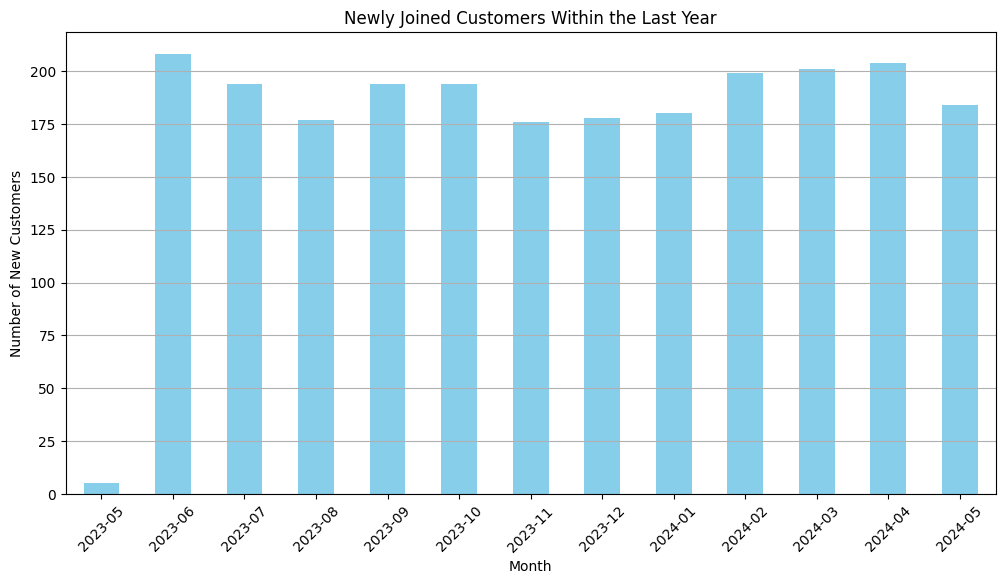

In [38]:

# Reference date
reference_date = pd.to_datetime('2024-05-31')

# Filter customers who joined within the last year
one_year_ago = reference_date - pd.DateOffset(years=1)
new_customers = customers[customers['join_date'] >= one_year_ago]

# Extract the month and year from the join_date
new_customers['join_month'] = new_customers['join_date'].dt.to_period('M')

# Count the number of customers who joined in each month
monthly_new_customers = new_customers['join_month'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(12, 6))
monthly_new_customers.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.title('Newly Joined Customers Within the Last Year')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [39]:
# almost uniformly distributed

In [40]:

# Filter out customers who joined after 2023-06-01, but keep them for prediction
existing_customers = customers[customers['join_date'] < pd.to_datetime('2023-06-01')]
new_customers = customers[customers['join_date'] >= pd.to_datetime('2023-06-01')]

# Define the date range
start_date = '2023-06-01'
end_date = '2024-05-31'
reference_date = pd.to_datetime(end_date)

# Filter transactions within the specified period
filtered_transactions = transactions[(transactions['transaction_date'] >= start_date) & (transactions['transaction_date'] <= end_date)]

# Filter marketing data within the specified period
filtered_marketing = marketing[(marketing['campaign_date'] >= start_date) & (marketing['campaign_date'] <= end_date)]

# Calculate total transaction amount for each customer within the specified period
customer_transaction_sums = filtered_transactions.groupby('customer_id')['transaction_amount'].sum().reset_index()
customer_transaction_sums.columns = ['customer_id', 'total_transaction_amount']

# Classify the top 50% customers as high-value customers
customer_transaction_sums = customer_transaction_sums.sort_values(by='total_transaction_amount', ascending=False)
num_high_value_customers = len(customer_transaction_sums) // 2
customer_transaction_sums['highvalue_customers'] = 0
customer_transaction_sums.iloc[:num_high_value_customers, customer_transaction_sums.columns.get_loc('highvalue_customers')] = 1

# Merge with the main customers dataframe
customers = pd.merge(customers, customer_transaction_sums[['customer_id', 'highvalue_customers']], on='customer_id', how='left')
customers['highvalue_customers'].fillna(0, inplace=True)  # Assign 0 to customers not in the top 50%

# Feature Engineering
# Recency: Days since last transaction
last_transaction_date = filtered_transactions.groupby('customer_id')['transaction_date'].max().reset_index()
last_transaction_date.columns = ['customer_id', 'last_transaction_date']
customers = pd.merge(customers, last_transaction_date, on='customer_id', how='left')
customers['recency'] = (reference_date - customers['last_transaction_date']).dt.days

# Frequency: Number of transactions within the year
transaction_frequency = filtered_transactions.groupby('customer_id').size().reset_index(name='frequency')
customers = pd.merge(customers, transaction_frequency, on='customer_id', how='left')
customers['frequency'].fillna(0, inplace=True)

# Lifespan: Days from join date to reference date
customers['lifespan'] = (reference_date - customers['join_date']).dt.days

# Positive Response: Number of 'Yes' responses within the year
positive_responses = filtered_marketing[filtered_marketing['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_response')
customers = pd.merge(customers, positive_responses, on='customer_id', how='left')
customers['positive_response'].fillna(0, inplace=True)

# Transaction Diversity: Number of different product categories purchased within the year
transaction_diversity = filtered_transactions.groupby('customer_id')['product_category'].nunique().reset_index(name='transaction_diversity')
customers = pd.merge(customers, transaction_diversity, on='customer_id', how='left')
customers['transaction_diversity'].fillna(0, inplace=True)

# Transaction Standard Deviation: Standard deviation of transaction amounts within the year
transaction_std = filtered_transactions.groupby('customer_id')['transaction_amount'].std().reset_index(name='transaction_standard_deviation')
customers = pd.merge(customers, transaction_std, on='customer_id', how='left')
customers['transaction_standard_deviation'].fillna(0, inplace=True)

# Engagement Metrics: Assume proportional to transaction frequency
total_transactions = transactions.groupby('customer_id').size().reset_index(name='total_transactions')
engagements = pd.merge(engagements, total_transactions, on='customer_id', how='left')
engagements['engagement_frequency'] = engagements['frequency'] / engagements['total_transactions']
engagements['engagement_frequency'].fillna(0, inplace=True)
engagements['site_visit'] = engagements['number_of_site_visits'] * engagements['engagement_frequency']
engagements['email_per_transaction'] = engagements['number_of_emails_opened'] * engagements['engagement_frequency']
engagements['click_per_transaction'] = engagements['number_of_clicks'] * engagements['engagement_frequency']

# Merge engagement features into customers dataframe
customers = pd.merge(customers, engagements[['customer_id', 'site_visit', 'email_per_transaction', 'click_per_transaction']], on='customer_id', how='left')

# Fill NaN values in engagement features
customers[['site_visit', 'email_per_transaction', 'click_per_transaction']] = customers[['site_visit', 'email_per_transaction', 'click_per_transaction']].fillna(0)

# Select the important features for modeling
modeling_features = ['age', 'gender', 'recency', 'frequency', 'lifespan', 'positive_response', 'transaction_diversity', 'transaction_standard_deviation', 'site_visit', 'email_per_transaction', 'click_per_transaction', 'highvalue_customers']

# Print the prepared columns
print(customers[modeling_features].head())


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/3281859926.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['highvalue_customers'].fillna(0, inplace=True)  # Assign 0 to customers not in the top 50%
/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_44193/3281859926.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

KeyError: 'frequency'